In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch 

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

from captum import attr

from ax.plot.contour import plot_contour, interact_contour
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import interact_cross_validation
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.feature_importances import plot_feature_importance_by_feature
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from ax.storage.json_store.load import load_experiment
from ax.storage.json_store.save import save_experiment

from ax.service.ax_client import AxClient, ObjectiveProperties

from ax.global_stopping.strategies.improvement import ImprovementGlobalStoppingStrategy
from ax.exceptions.core import OptimizationShouldStop

from botorch.acquisition.analytic import LogNoisyExpectedImprovement
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior

# Load data

Spectral data collected at 2 nm intervals 400-2250 nm & converted to absorbance units.

(40, 926)
Grid size: 926
(40,)


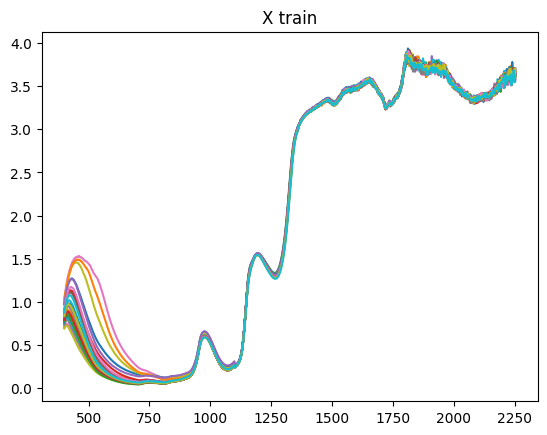

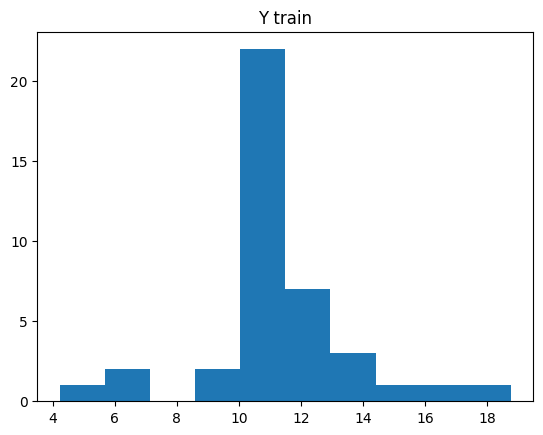

(20, 926)
(20,)


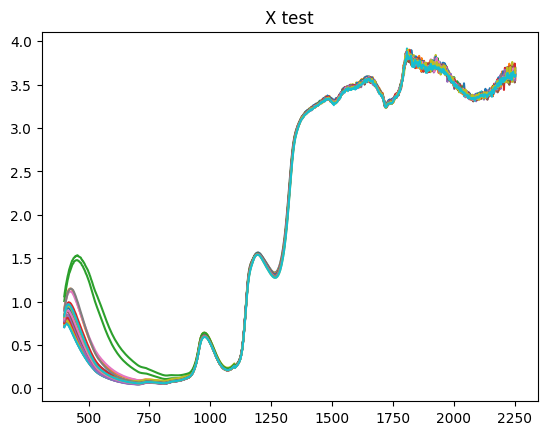

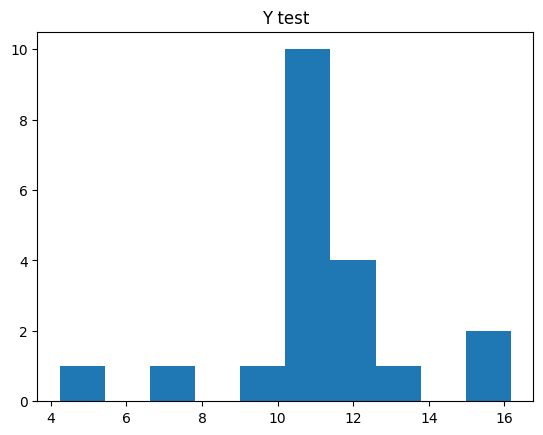

In [2]:
# Sampling grid
grid = np.linspace(400, 2252, 926)

# training data
data_train = pd.read_csv('Data/beer_spectra.csv', header=None)

x_train = data_train.values[:,:-1]
print(x_train.shape)

print('Grid size:', x_train.shape[1])
# 
y_train = data_train.values[:,-1]
print(y_train.shape)

plt.figure()
plt.plot(grid, x_train.T)
plt.title('X train')
plt.show()

plt.figure()
plt.hist(y_train)
plt.title('Y train') 
plt.show()

# testing data
data_test = pd.read_csv('Data/beer_spectra_test.csv', header=None)

x_test = data_test.values[:,:-1]
print(x_test.shape)

y_test = data_test.values[:,-1]
print(y_test.shape)

plt.figure()
plt.plot(grid, x_test.T)
plt.title('X test')
plt.show()

plt.figure()
plt.hist(y_test)
plt.title('Y test') 
plt.show()

# save grid
df_grid = pd.DataFrame(data=grid)
# df_grid.to_csv('Data/wavelenghts.csv', header=None, index=None)

In [ ]:
name = 'haar'
levels = [2, 3, 4, 5]
file_name = 'Data/rec_spectra_'+ name + '_' + str(levels[3]) + '_train.csv'
x_train = pd.read_csv(file_name, header=None).values

plt.figure()
plt.plot(grid, x_train.T)
plt.title('X train')

# CNN

In [3]:
# Create Dataset 
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).reshape(-1, 1)
        self.transform = None
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        sample =  self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

def weights_init(m, init_type):
    # init_type = m.init_type
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        if init_type == 'kaiming_uniform':
            nn.init.kaiming_uniform_(m.weight)
            nn.init.zeros_(m.bias)
        elif init_type == 'xavier_uniform':
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
        elif init_type == 'kaiming_normal':
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)
        else:
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    else:
        pass

# CNN class
class CNN(nn.Module):

    def __init__(self, params, x_shape, y_shape, channels_in=1):
        ''' Initiate model
        args:
        params - dict{act, n_filters, kernel_size, pool_size, units}
        x_shape - length of input signal
        y_shape -  size of output variable
        ''' 
        super(CNN, self).__init__()

        # set attributes 
        for key, value in params.items():
            setattr(self, key, value)

        if self.act in ['elu, relu']:
            self.init_type = 'kaiming_normal'
        else:
            self.init_type = 'xavier_uniform'

        # setup available activation functions
        self.act_funcs = {
            'sigmoid': nn.Sigmoid,
            'tanh': nn.Tanh,
            'relu': nn.ReLU,
            'elu': nn.ELU,
        }

        # map string to activation function - same activation function for all layers
        self.act = self.act_funcs[self.act]()

        # Define layers
        self.conv1 = nn.Conv1d(channels_in, self.n_filters,  self.kernel_size, padding='same')
        if self.use_batch_norm:
            self.batch_norm = nn.BatchNorm1d(channels_in *  self.n_filters, affine=True) # size of batch norm = n_channels x n_filters

        # Pooling 
        if self.pool_type == 'max_pool':
            self.pool = nn.MaxPool1d(self.pool_size) 
        elif self.pool_type == 'avg_pool':
            self.pool = nn.AvgPool1d(self.pool_size)         
        else:
            self.pool = None

        self.size_after_pool = self.n_filters * int(x_shape/ self.pool_size) if self.pool_type in ['max_pool', 'avg_pool'] else x_shape

        # Flatten
        self.flat = nn.Flatten(1, -1) # flatten all dimensions except batch (second and third dimension)

        # Dense layers
        self.hidden_layers = nn.Sequential()
        for i in range(self.n_hidden_layers):
            if i == 0: # first layer after conv block
                self.hidden_layers.append(nn.Linear(self.size_after_pool,  self.units))
                self.hidden_layers.append(self.act)
                if self.use_batch_norm:
                    self.hidden_layers.append(nn.BatchNorm1d( self.units, affine=True))

            else:
                self.hidden_layers.append(nn.Linear( self.units, self.units))
                self.hidden_layers.append(self.act)
                if self.use_batch_norm:
                    self.hidden_layers.append(nn.BatchNorm1d( self.units, affine=True))

        self.output_layer = nn.Linear( self.units, y_shape)

        # initialize weights
        self.apply(lambda m: weights_init(m, self.init_type))

    # calculate output
    def forward(self, x):
        # conv block
        x = self.conv1(x)
        x = self.act(x)
        if self.use_batch_norm:
            x = self.batch_norm(x)
        if self.pool is not None:
            x = self.pool(x)
        # flat
        x = self.flat(x)
        # dense block
        x = self.hidden_layers(x)
        # last layer
        x = self.output_layer(x)
        return x
    

def train_net(dataloader, model, loss_fn, optimizer, epochs, device, verbose, scheduler):

    size = len(dataloader)
    model.train()
    loss_ = np.zeros(epochs)

    if verbose == True:
        print("Beginning training")
        
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.unsqueeze(1).to(device), y.to(device)
            
            optimizer.zero_grad()

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            loss, current = loss.item(), (batch + 1) * len(X)
            if verbose == True:
                if batch % 100 == 0:
                    print(f"epoch: {epoch}, loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_[epoch] = loss

        # scheduler
        if scheduler is not None:
            # scheduler after 100 epochs
            if epoch >= 100:
                scheduler.step(loss)
            else:
                pass

    model.eval()

    return loss_, model

def test_net(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for _, (X, y) in enumerate(dataloader):
            X, y = X.unsqueeze(1).to(device), y.to(device)
        if not device == 'cpu':
            ypred = model(X).cpu()
        else: 
            ypred = model(X)
        return ypred

def get_feature_maps(dataloader, model, n_filters, device, grid):
    model.eval()
    with torch.no_grad():
        for _, (X, _) in enumerate(dataloader):
            X = X.unsqueeze(1).to(device)
        if not device == 'cpu':
            feature_maps = torch.squeeze(model.act(model.conv1(X))).cpu()
        else:
            feature_maps = torch.squeeze(model.act(model.conv1(X)))

        if n_filters > 1:
            feature_maps_mean = [torch.mean(feature_maps[:,i,:], 0).detach().numpy() for i in range(n_filters)]
            fig, ax =  plt.subplots(n_filters, 1, figsize=(20,20), sharex=True)
            for k in range(n_filters):
                ax[k].plot(grid, feature_maps_mean[k], '--')
                ax[k].set_title(f'Filter {k}')
        else:
            feature_maps_mean = feature_maps.mean(axis=0)
            plt.figure()
            plt.plot(grid, feature_maps_mean.detach().numpy(), '--')   

    return feature_maps_mean, feature_maps

# function to reset weights
@torch.no_grad()
def reset_weights(model):
    for layer in model.children():
        # check if is sequential layer
        if isinstance(layer, nn.Sequential):
        # cycle through hidden layers in sequential module
            for layer_seq in layer.children():
                if hasattr(layer_seq, 'reset_parameters'):
                    layer_seq.reset_parameters()
        elif hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


def cross_validation(X_data, Y_data, K_fold, model, epochs, loss_fn, optimizer, device, verbose, scheduler, score_fun, **kwargs):

    kf = KFold(n_splits=K_fold, shuffle=True)
    
    # Train model for each data fold
    score_val_cv = np.zeros((K_fold))
    for i, (train_id, test_id) in enumerate(kf.split(X_data, Y_data)): 
        # Train and val data
        xtrain, ytrain = X_data[train_id, :], Y_data[train_id]
        xval, yval = X_data[test_id, :], Y_data[test_id]

        # Dataset and dataloaders (todo: add batch size)
        dataset_train = CustomDataset(xtrain, ytrain)
        dataset_val = CustomDataset(xval, yval)
        dataloader_train  = DataLoader(dataset_train, batch_size=xtrain.shape[0], shuffle=False)
        dataloader_val = DataLoader(dataset_val, batch_size=yval.shape[0], shuffle=False)

        # reset model parameters and initialize weights
        model.apply(reset_weights)
        # model.apply(weights_init, model.init_type)
        model.apply(lambda m: weights_init(m, model.init_type))

        # Train model
        train_net(dataloader_train, model, loss_fn, optimizer, epochs, device, verbose, scheduler)

        # Calculate score function on validation data
        ypred_val = test_net(model, dataloader_val, device).detach().numpy()
        score_val_cv[i] = score_fun(yval, ypred_val, **kwargs)

    score_val_cv_mean = np.mean(score_val_cv)

    return score_val_cv_mean, score_val_cv

def train_test_qr(x_train, y_train, x_test, y_test, df_Q, df_R, params, loss_fn, score_fun, epochs=500, device='cuda', verbose=False, scheduler=None):
    # indices
    ids_q, ids_r = df_Q.values - 1, df_R.values - 1        
    Q, R = df_Q.shape[0], df_R.shape[0]
    x_shape = x_train.shape[1]
    batch_size = ids_q.shape[1]
    batch_size_test = ids_r.shape[1]
    
    # rows are train ids, columns are test ids
    kpi_test = np.zeros((Q, R))

    # cycle through Q training 
    for i in range(Q):
        # select training samples from dataset
        dataset_train = CustomDataset(x_train[ids_q[i,:],:], y_train[ids_q[i,:]])
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

        # train model
        cnn = CNN(params, x_shape, 1).to(device)
        optimizer = torch.optim.Adam(cnn.parameters(), lr=cnn.lr, weight_decay=cnn.l2)
        loss, cnn = train_net(dataloader_train, cnn, loss_fn, optimizer, epochs, device, verbose, scheduler)  

        # cycle through R test partitions
        for j in range(R):
            # select training samples from dataset
            dataset_test = CustomDataset(x_test[ids_r[j,:],:], y_test[ids_r[j,:]])
            dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False)

            # test model
            y_pred_test = test_net(cnn, dataloader_test, device)
            kpi_test[i, j] = score_fun(y_test[ids_r[j,:]], y_pred_test)
        print('Iter Q:', i, 'mean kpi_test', kpi_test[i, :].mean())

    return kpi_test

def train_test(dataloader_train, dataloader_test, params, epochs=500, device='cuda', verbose=False, scheduler=None, n=100):
    x_shape = x_train.shape[1]
    rmse_train, rmse_test = np.zeros(n), np.zeros(n)

    for i in range(n):
        print('iter', i)
        cnn = CNN(params, x_shape, 1).to(device)
        loss_fn = nn.MSELoss() 
        optimizer = torch.optim.Adam(cnn.parameters(), lr=cnn.lr, weight_decay=cnn.l2)
        loss, cnn = train_net(dataloader_train, cnn, loss_fn, optimizer, epochs, device, verbose, scheduler)

        # Make predictions
        y_pred_train = test_net(cnn, dataloader_train, device)
        y_pred_test = test_net(cnn, dataloader_test, device)  
        
        rmse_train[i] = root_mean_squared_error(y_train, y_pred_train)
        rmse_test[i] = root_mean_squared_error(y_test, y_pred_test)

    return rmse_train, rmse_test

Train model

In [ ]:
x_data, y_data = x_train, y_train
print(x_data.shape, y_data.shape)

# generate dataset
dataset = CustomDataset(x_data, y_data)
dataset_test = CustomDataset(x_test, y_test)

# no batch training
dataloader = DataLoader(dataset, batch_size=x_data.shape[0], shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=y_test.shape[0], shuffle=False)

In [ ]:
device = "cuda"
# device = "cpu"

# torch.manual_seed(0)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(0)
# torch.backends.cudnn.deterministic = True 

# initialize model
params = {
    'n_filters': 1,
    'kernel_size': 31,
    'pool_size': 3,
    'n_hidden_layers': 1,
    'units': 30,
    'act': 'elu',
    'l2': 1e-2,
    'lr': 1e-3,
    'pool_type': 'avg_pool',
    'use_batch_norm': False
}

x_shape = x_data.shape[-1]
cnn = CNN(params, x_shape, 1).to(device)
print(cnn)

# Loss function and optimizer 
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=cnn.lr, weight_decay=cnn.l2)

epochs = 500
verbose = False
scheduler = None

loss_, cnn = train_net(dataloader, cnn, loss_fn, optimizer, epochs, device, verbose, scheduler)

plt.figure()
plt.plot(np.array(loss_))

# feature maps
get_feature_maps(dataloader, cnn, cnn.n_filters, device, grid)

# Make predictions
y_pred_train = test_net(cnn, dataloader, device)
y_pred_test = test_net(cnn, dataloader_test, device)

R2_train = r2_score(y_data, y_pred_train)
rmse_train = root_mean_squared_error(y_data, y_pred_train)
print('R2_train, rmse_train', R2_train, rmse_train)

plt.figure()
plt.plot(y_pred_train, y_data, 'o')

R2_test = r2_score(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
print('R2_test, rmse_test', R2_test, rmse_test)

plt.figure()
plt.plot(y_pred_test, y_test, 'o')

# Hyper-parameter optimization

In [ ]:
def cv_net(params, dataset_name, y_data, **kwargs):

  if dataset_name == 'raw':
    file_name_train = 'Data/beer_spectra.csv' 
    x_data = pd.read_csv(file_name_train, header=None).values[:,:-1]

  elif dataset_name in ['haar', 'db6', 'sym6']:
    wav_level = params['wav_levels']
    file_name_train = 'Data/rec_spectra_'+ dataset_name + '_' + str(wav_level) + '_train.csv'
    x_data = pd.read_csv(file_name_train, header=None).values

  else:
    file_name_train = 'Data/' + dataset_name + '_train' + '.csv'
    x_data = pd.read_csv(file_name_train, header=None).values

  # pop wav_level from params (not relevant as a CNN attribute)
  params.pop('wav_levels')

  score_fun = root_mean_squared_error
  scheduler = None
  epochs = 3 if kwargs.get('smoke_test') else 500
  kfold = 2 if kwargs.get('smoke_test') else 10
  device = "cuda" if kwargs.get('smoke_test') else 'cpu'
  x_shape = x_train.shape[-1]    

  # fix parameters a priori
  params['n_filters'] = 1
  params['pool_size'] =  3
  params['n_hidden_layers'] = 1
  params['use_batch_norm'] = False

  # torch.manual_seed(0)
  loss_fn = nn.MSELoss()
  model = CNN(params, x_shape, 1).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=model.lr, weight_decay=model.l2)    
  rmse_cv, _ = cross_validation(x_data, y_data, kfold, model, epochs, loss_fn, optimizer, device, False, scheduler, score_fun, 
                                ) 
  return {"RMSE_CV": (rmse_cv)}

In [ ]:
test_par={
 'kernel_size': 31,
 'units': 30,
 'act': 'elu',
 'lr': 1e-2,
 'l2': 1e-03,
 'pool_type': 'max_pool',
 'wav_levels': 4}

cv_net(test_par, 'sym6', y_train)

In [ ]:
SMOKE_TEST = False

n_sobol = 2 if SMOKE_TEST else 10*5
n_BO = 2 if SMOKE_TEST else 150
n_total = n_sobol + n_BO

# Generation strategy
sobol_step = GenerationStep(model=Models.SOBOL, num_trials=n_sobol, max_parallelism=1)

gp_step = GenerationStep(model = Models.BOTORCH_MODULAR, 
                         num_trials = -1,  
                         model_kwargs = {"surrogate": Surrogate(
                                                                botorch_model_class = MixedSingleTaskGP,
                                                                model_options = {'categorical_features': [0, 1,]},      # indices of categorical features
                                                                input_transform_classes = [Warp],   
                                                                input_transform_options = {'Warp': {'concentration0_prior': LogNormalPrior(0.0, 0.75**0.5),
                                                                                                    'concentration1_prior': LogNormalPrior(0.0, 0.75**0.5),
                                                                                                    'indices': list(range(2,
                                                                                                                          6))                # warp only continuous parameters
                                                                                                    },
                                                                                                    },
                                                                ),
                                        #  "botorch_acqf_class": LogNoisyExpectedImprovement, 
                                         "torch_device": torch.device("cuda")
                                         },)
          
# Stopping strategy
stopping_strategy = ImprovementGlobalStoppingStrategy(min_trials = n_sobol + 20, 
                                                      window_size = 20, 
                                                      improvement_bar = 0.01
                                                      )

# cycle through datasets
# pp_names = [
#             'raw', 
#             'MC', 
#             'MSC', 
#             'SNV', 
#             'SGD-2-9',
#             'SNV-SGD-2-9'
#             ]

pp_names = [
            'haar', 
            'db6', 
            'sym6', 
            ]

for i, name in enumerate(pp_names):
  # select data set
  print('Starting optimization for dataset:', name)
  
  y_data = y_train

  gs = GenerationStrategy(steps=[sobol_step, gp_step])

  # Initialize AxClient 
  ax_client = AxClient(generation_strategy=gs, 
                     verbose_logging=True, 
                     global_stopping_strategy=stopping_strategy,
                     )

  # Setup the experiment
  ax_client.create_experiment(
          name = "HPO_beer_" + name,
          parameters = [
            {
              "name": "pool_type",
              "type": "choice", 
              "values": ['max_pool', 'avg_pool', 'no_pool'],
              "value_type": "str",  
              'is_ordered': False,
              'sort_values': False
            },
            {
              "name": "act",
              "type": "choice", 
              "values": ['sigmoid', 'tanh', 'relu', 'elu'],
              "value_type": "str",  
              'is_ordered': False,
              'sort_values': False
            },
            {
              "name": "wav_levels",
              "type": "range",
              "bounds": [2, 5],
              "value_type": "int",
            },
            {
              "name": "units",
              "type": "range",
              "bounds": [10, 100],
              "value_type": "int",
            },
            {
              "name": "kernel_size",
              "type": "range",
              "bounds": [32, 128],
              "value_type": "int",  
            },
            {
              "name": "l2",
              "type": "range",
              "bounds": [1e-5, 1.0e-1],
              "value_type": "float",  
            },
            {
              "name": "lr",
              "type": "range",
              "bounds": [1.0e-4, 1.0e-2],
              "value_type": "float", 
            }
          ],
          objectives={"RMSE_CV": ObjectiveProperties(minimize=True)},
          overwrite_existing_experiment=True # True retriggers new generation strategy selection
  )

  # run BO loop
  for k in range(n_total):
    try:
        # get next trial
        parameters, trial_index = ax_client.get_next_trial()
    # early stopping condition
    except OptimizationShouldStop as exc:
        print(exc.message)
        break
      
    # evaluate parameters and complete trial
    obj_fun = cv_net(parameters, name, y_train, smoke_test=SMOKE_TEST)
    ax_client.complete_trial(trial_index=trial_index, raw_data=obj_fun)

  # get best parameters
  print('best_par', ax_client.get_best_parameters())
  # best_parameters, values = ax_client.get_best_parameters()
  
  # file name
  file_name_client = 'ax_client_' + name + '.json'
  file_name_exp = 'ax_exp_' + name + '.json'

  # save ax_client object (including settings, generation_stategy, etc)
  ax_client.save_to_json_file(file_name_client)
  
  # save experiment
  save_experiment(ax_client.experiment, file_name_exp)

### Load best hyper-parameters

In [ ]:
hp_dict = {}

# Load ax client
for name in pp_names:
    ax = AxClient.load_from_json_file('ax_client_' + name + '.json')
    print(name, ax.experiment.num_trials)
    best_par, values = ax.get_best_parameters()
    hp_dict[name] = best_par
    hp_dict[name]['n_filters'] = 1
    hp_dict[name]['pool_size'] =  3
    hp_dict[name]['n_hidden_layers'] = 1
    hp_dict[name]['use_batch_norm'] = False

    print(best_par, values)

# create dataframe
hp_df = pd.DataFrame.from_dict(hp_dict, orient='index')
hp_df

In [ ]:
# hp_df.to_csv('hpo_results/best_hps.csv')
hp_df.to_csv('hpo_results/best_hps_wav.csv')

# Train CNN on Q/R splits


Store the results in a QxR matrix
|     | 1   |     | 2   |     | R   |     |
| --- | --- | --- | --- | --- |--- | --- |
|1 | F1 | F2 | F1 | F2 |  F1 | F2 |
|2 | F1 | F2 | F1 | F2 |  F1 | F2 |
|Q | F1 | F2 | F1 | F2 |  F1 | F2 |

In [ ]:
# load indices for Q splits (columns are samples ids, rows are different partitions)
df_q = pd.read_csv('Data/ss-dac-train-id-Q.csv', header=None)
print(df_q.values.shape)

# load indices for R splits, obtained using 2-fold CV with 10 repetitions (columns are samples ids, rows are different folds, every two rows are two folds)
df_r =pd.read_csv('Data/ss-dac-test-id-R.csv', header=None)
print(df_r.values.shape)

In [ ]:
# best_hp_df = pd.read_csv('hpo_results/best_hps.csv', header=[0], index_col=[0])
best_hp_df = pd.read_csv('hpo_results/best_hps_wav.csv', header=[0], index_col=[0])
pp_names = best_hp_df.index.to_list()
best_hp_df

In [ ]:
loss_fn = nn.MSELoss()
score_fun = root_mean_squared_error

rmse_test = {}
for name in pp_names:
    print(name)
    best_par = best_hp_df.loc[name].to_dict()
    if name == 'raw':
        file_name_train = 'Data/beer_spectra.csv'
        file_name_test = 'Data/beer_spectra_test.csv'
        x_data_train = pd.read_csv(file_name_train, header=None).values[:,:-1]
        x_data_test = pd.read_csv(file_name_train, header=None).values[:,:-1]

    elif name in ['haar', 'db6', 'sym6']:
        wav_level = best_par['wav_levels']
        file_name_train = 'Data/rec_spectra_'+ name + '_' + str(wav_level) + '_train.csv'
        file_name_test = 'Data/rec_spectra_'+ name + '_' + str(wav_level) + '_test.csv'
        x_data_train = pd.read_csv(file_name_train, header=None).values
        x_data_test = pd.read_csv(file_name_test, header=None).values

    else:
        file_name_train = 'Data/' + name + '_train' + '.csv'
        file_name_test = 'Data/' + name + '_test' + '.csv'
        x_data_train = pd.read_csv(file_name_train, header=None).values
        x_data_test = pd.read_csv(file_name_test, header=None).values
    
    # train test q/r
    rmse = train_test_qr(x_data_train, y_train, x_data_test, y_test, df_q, df_r, best_par, loss_fn, score_fun)
    rmse_test[name] = rmse

# save to csv
for name in rmse_test.keys():
    file_name = 'Results/KPI/kpi_CNN_' + name + '.csv'
    df = pd.DataFrame(data=rmse_test[name])
    df.to_csv(file_name, header=False, index=False,) 

In [ ]:
pp_names = [
    'raw', 
    'MC', 'MSC', 'SGD-2-9', 'SNV', 'SNV-SGD-2-9',
    'haar', 'db6', 'sym6'
    ]

rmse_test_list = []
for name in pp_names:
    # rmse = rmse_test[name].reshape(-1)
    file_name = 'Results/KPI/kpi_CNN_' + name + '.csv'
    rmse = pd.read_csv(file_name, index_col=[0]).values.reshape(-1)
    rmse_test_list.append(rmse)
    print(f'{name}, mean={rmse.mean()}, std={rmse.std()}')

plt.boxplot(rmse_test_list,tick_labels=pp_names)
plt.show()

In [ ]:
rmse_test = rmse_test['MSC']

med = np.mean(rmse_test.reshape(-1))
std = np.std(rmse_test.reshape(-1))
print('median', med, 'std', std)

plt.figure()
plt.boxplot(rmse_test.reshape(-1))

# by folds
id_fold1 = np.arange(0,20,2)
id_fold2 = np.arange(1,20,2)

med_1 = np.median(rmse_test[:,id_fold1].reshape(-1))
med_2 = np.median(rmse_test[:,id_fold2].reshape(-1))

print(med_1, med_2)

plt.figure()
plt.boxplot([rmse_test[:,id_fold1].reshape(-1), rmse_test[:,id_fold2].reshape(-1)])
plt.title('By folds')

# Interpretability

In [13]:
best_hp_df = pd.read_csv('hpo_results/best_hps.csv', header=[0], index_col=[0])
best_hp_df_wav = pd.read_csv('hpo_results/best_hps_wav.csv', header=[0], index_col=[0])
best_hp_df.insert(0, "wav_levels", [0, 0, 0, 0, 0, 0])

In [ ]:
best_hp_df_all = pd.concat((best_hp_df, best_hp_df_wav))
best_hp_df_all.to_csv('hpo_results/best_hps_all.csv')
best_hp_df_all

In [4]:
best_hp_df_all = pd.read_csv('hpo_results/best_hps_all.csv', header=[0], index_col=[0])
best_hp_df_all

,wav_levels,units,kernel_size,l2,lr,pool_type,act,n_filters,pool_size,n_hidden_layers,use_batch_norm
raw,0,45,128,0.086836,0.001239,no_pool,relu,1,3,1,False
MC,0,90,128,0.000010,0.009507,max_pool,elu,1,3,1,False
MSC,0,56,33,0.001038,0.007198,avg_pool,elu,1,3,1,False
SNV,0,61,128,0.055985,0.005225,avg_pool,elu,1,3,1,False
SGD-2-9,0,92,38,0.011976,0.004512,max_pool,sigmoid,1,3,1,False
SNV-SGD-2-9,0,89,126,0.031123,0.005976,max_pool,sigmoid,1,3,1,False
haar,3,78,35,0.059711,0.006857,avg_pool,relu,1,3,1,False
db6,2,74,101,0.040568,0.007319,avg_pool,tanh,1,3,1,False
sym6,3,100,50,0.028226,0.007463,max_pool,tanh,1,3,1,False


In [5]:
def train_and_get_feature_maps_importance(grid, pp_name, hp_df, method, n_iter=2, device='cuda', epochs=500, verbose=False, scheduler=None):

    best_par = hp_df.loc[pp_name].to_dict()

    if pp_name == 'raw':
        file_name_train = 'Data/beer_spectra.csv'
        x_data = pd.read_csv(file_name_train, header=None).values[:,:-1]

    elif pp_name in ['haar', 'db6', 'sym6']:
        wav_level = best_par['wav_levels']
        file_name_train = 'Data/rec_spectra_'+ pp_name + '_' + str(wav_level) + '_train.csv'
        x_data = pd.read_csv(file_name_train, header=None).values
    else:
        file_name_train = 'Data/' + pp_name + '_train' + '.csv'
        x_data = pd.read_csv(file_name_train, header=None).values

    y_data = pd.read_csv('Data/beer_spectra.csv', header=None).values[:,-1]

    # generate dataset
    dataset = CustomDataset(x_data, y_data)
    batch_size = x_data.shape[0] # no batch training
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for _, (X_fi, _) in enumerate(dataloader):
        X_fi = X_fi.unsqueeze(1).to(device)

    # initialize model
    x_shape = x_data.shape[-1]
    loss_fn = nn.MSELoss()

    # repeat training for n_iter iterations, and perform attribution for each iter
    x_attr = torch.zeros((n_iter, batch_size, x_shape))

    for i in range(n_iter):
        # train cnn
        cnn_best = CNN(best_par, x_shape, 1).to(device)
        optimizer = torch.optim.Adam(cnn_best.parameters(), lr=cnn_best.lr, weight_decay=cnn_best.l2)
        loss_, cnn_best = train_net(dataloader, cnn_best, loss_fn, optimizer, epochs, device, verbose, scheduler)

        # Make predictions
        y_pred_train = test_net(cnn_best, dataloader, device)
        R2_train = r2_score(y_data, y_pred_train)
        rmse_train = root_mean_squared_error(y_data, y_pred_train)
        print('R2 train', R2_train, 'RMSE train', rmse_train)

        # set model to eval
        cnn_best.eval()

        # # feature maps
        # feature_maps_mean, _ = get_feature_maps(dataloader, cnn_best, cnn_best.n_filters, device, grid)

        if method == 'ig':
            att_method = attr.IntegratedGradients(cnn_best)
            attr_iter = att_method.attribute(X_fi, n_steps=100).squeeze().cpu().detach()

        elif method == 'shap':
            att_method = attr.ShapleyValueSampling(cnn_best)
            attr_iter = att_method.attribute(X_fi, n_samples=25).squeeze().cpu().detach()

        else:
            att_method = attr.Occlusion(cnn_best)
            attr_iter = att_method.attribute(X_fi, sliding_window_shapes=(1,10)).squeeze().cpu().detach()

        x_attr[i, :] = attr_iter

    x_attr_mean_per_spectra = x_attr.mean(axis=0)
    
    return x_attr_mean_per_spectra

In [6]:
# train and get feature importance
grid = np.linspace(400, 2252, 926) 

ig_features_mc = train_and_get_feature_maps_importance(grid, 'MC', best_hp_df_all, 'shap', n_iter=30)

plt.figure()
plt.plot(grid, ig_features_mc.T)
plt.xlabel('Wavelenght (nm)')
plt.ylabel('Absolute integrated gradient values')

c:\Users\Utilizador\miniconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\conv.py:370: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1037.)



R2 train 0.999780386286199 RMSE train 0.03567904304240078
R2 train 0.9993018395787654 RMSE train 0.06361522710311016
R2 train 0.9996478315397103 RMSE train 0.04518129750462641
R2 train 0.999639748927642 RMSE train 0.04569683384631498
R2 train 0.9995253931818558 RMSE train 0.0524505994333526
R2 train 0.9995314092614979 RMSE train 0.05211710935052316
R2 train 0.9993429041350617 RMSE train 0.061716009403115474
R2 train 0.9997677135529788 RMSE train 0.036694029437541895
R2 train 0.9992364874770561 RMSE train 0.0665260214897066
R2 train 0.9988434465172416 RMSE train 0.08187783107955818
R2 train 0.9997055132415099 RMSE train 0.04131581796220657
R2 train 0.9995165238871629 RMSE train 0.052938420619275686
R2 train 0.9991296626394859 RMSE train 0.07102762330730233
R2 train 0.9991876537588709 RMSE train 0.06862052826084786
R2 train 0.9995123889184611 RMSE train 0.05316431871450922
R2 train 0.9994206028898511 RMSE train 0.057952427431026306
R2 train 0.9992199856346384 RMSE train 0.067241093884639

NameError: name 'ig_features' is not defined

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Absolute integrated gradient values')

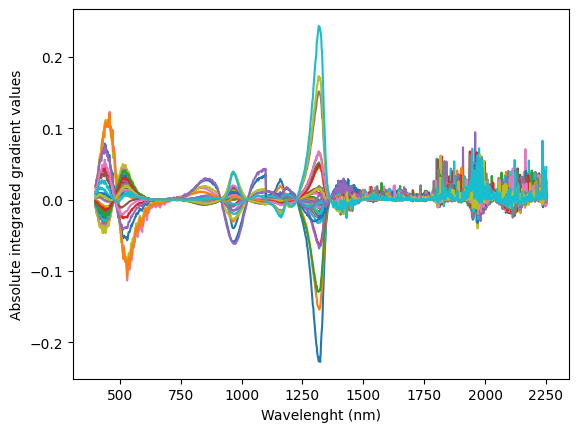

In [7]:
plt.figure()
plt.plot(grid, ig_features_mc.T)
plt.xlabel('Wavelenght (nm)')
plt.ylabel('Absolute integrated gradient values')

In [8]:
# Save integrated gradients
intrepretability_data = pd.DataFrame(data=ig_features_mc.numpy(), index=None, columns=None)
intrepretability_data.to_csv('shap_cnn_MC_beer.csv', index=None, header=None)

R2 train 0.2657697773429102 RMSE train 2.0630017576934354
R2 train 0.3492189204350502 RMSE train 1.942231209364637
R2 train 0.12304375230184739 RMSE train 2.254615210918353
R2 train 0.6576473225682121 RMSE train 1.4087059007929443
R2 train 0.38421715499690445 RMSE train 1.8892840683138892
R2 train 0.6222460655191089 RMSE train 1.4797487018177735
R2 train 0.35581966642529417 RMSE train 1.9323562688348825
R2 train 0.3764156555249516 RMSE train 1.9012142953579905
R2 train 0.3673879303894362 RMSE train 1.9149269275882215
R2 train 0.3937077834580126 RMSE train 1.874668430347369
R2 train 0.5711775387050249 RMSE train 1.5766025767670593
R2 train 0.5556519234694213 RMSE train 1.604889448356621
R2 train 0.5938705616453379 RMSE train 1.5343191469928186
R2 train 0.3159335304113564 RMSE train 1.991281326682165
R2 train 0.004717372615346549 RMSE train 2.4019097285853745
R2 train 0.4597141844584637 RMSE train 1.7696820766557084
R2 train 0.6241947216060029 RMSE train 1.475927100824759
R2 train 0.3525

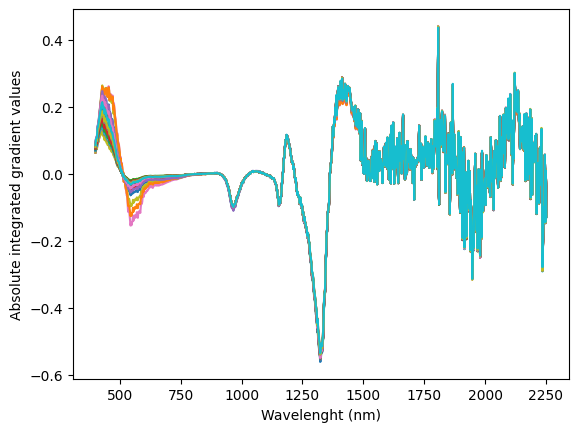

In [9]:
ig_features_raw = train_and_get_feature_maps_importance(grid, 'raw', best_hp_df_all, 'shap', n_iter=30)

plt.figure()
plt.plot(grid, ig_features_raw.T)
plt.xlabel('Wavelenght (nm)')
plt.ylabel('Absolute integrated gradient values')

# Save integrated gradients
intrepretability_data = pd.DataFrame(data=ig_features_raw.numpy(), index=None, columns=None)
intrepretability_data.to_csv('shap_cnn_raw_beer.csv', index=None, header=None)